#Autoencoder

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

In [33]:
dataset_path = "C:/Users/dakee/Downloads/archive/landscape Images/color"

dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    label_mode=None,
)

Found 7129 files.


In [34]:
def rgb_to_grayscale(image):
    return tf.image.rgb_to_grayscale(image)


def preprocess(image):
    grayscale_image = rgb_to_grayscale(image)
    return grayscale_image, image  

dataset = dataset.map(preprocess)

def normalize(grayscale_image, color_image):
    return grayscale_image / 255.0, color_image / 255.0

dataset = dataset.map(normalize)

input_shape = (150, 150, 1)

In [35]:
# 🔹 Encoder
encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Flatten()(x)
encoder_output = layers.Dense(256, activation='relu')(x)

encoder = models.Model(encoder_input, encoder_output, name="encoder")

# 🔹 Decoder
decoder_input = layers.Input(shape=(256,))  # La salida del encoder es de tamaño 256
x = layers.Dense(37 * 37 * 128, activation='relu')(decoder_input)  # Ajustado para 150x150
x = layers.Reshape((37, 37, 128))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)  # Sin strides=2 aquí

# Ajustar las dimensiones a (150, 150) si es necesario
if x.shape[1] != 150 or x.shape[2] != 150:
    x = tf.keras.layers.Resizing(150, 150)(x)  # Usar tf.keras.layers.Resizing

decoder_output = x

decoder = models.Model(decoder_input, decoder_output, name="decoder")

In [36]:
autoencoder_input = layers.Input(shape=input_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
colorization_model = models.Model(autoencoder_input, decoded, name="colorization_model")

colorization_model.compile(optimizer='adam', loss='mse')

colorization_model.summary()

Model: "colorization_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 256)            │    11,922,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 150, 150, 3)    │    45,127,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,049,923 (217.63 MB)

 Trainable params: 57,049,923 (217.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = colorization_model.fit(dataset, epochs=50)

223/223 ━━━━━━━━━━━━━━━━━━━━ 1010s 4s/step - loss: 0.0569


In [39]:
colorization_model.save("colorization2_model_150x150.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


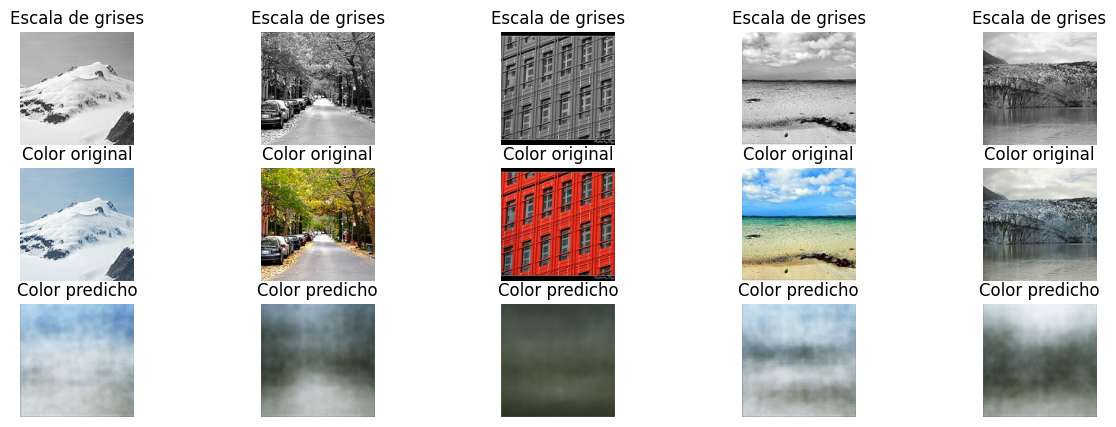

In [40]:
def visualize_results(dataset, model, num_images=5):
    for grayscale_images, color_images in dataset.take(1):

        predicted_colors = model.predict(grayscale_images)


        plt.figure(figsize=(15, 5))
        for i in range(num_images):

            plt.subplot(3, num_images, i + 1)
            plt.imshow(grayscale_images[i].numpy().squeeze(), cmap='gray')
            plt.title("Escala de grises")
            plt.axis('off')

            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(color_images[i].numpy())
            plt.title("Color original")
            plt.axis('off')

            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(predicted_colors[i])
            plt.title("Color predicho")
            plt.axis('off')

        plt.show()


visualize_results(dataset, colorization_model)